In [ ]:
# La biblioteca stanza nos permite realizar procedimientos como la 
#lemmatizacion
pip install stanza

In [ ]:
#la biblioteca de google translate nos permite conectarnos a la api de traduccion
#de google y usarla para traducir
pip install googletrans==3.1.0a0

In [251]:
import pandas as pd 
import re 
import nltk 
from nltk.corpus import stopwords
import re
nltk.download('punkt')
nltk.download('stopwords')
import stanza
import pdb
import pickle
import string

import time
from collections import Counter
import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import scipy
import sklearn
from gensim.models import KeyedVectors
from nltk.corpus import stopwords, twitter_samples
from nltk.tokenize import TweetTokenizer
import pandas as pd
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors
from google.colab import files
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
#Visualizacion
import plotly.express as px
import plotly.graph_objects as go 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#Con esta funcion podemos utilizar la biblioteca de stanza en google coolab
#ya que si esta funcion cada vez que intentemos utilizar stanza en google
#coolab nos marcara un error 
stanza.download('en', package='default', processors='tokenize,sentiment', verbose=True)
stNLP = stanza.Pipeline(processors='tokenize,sentiment', lang='en', use_gpu=True)
def stanza_funct(text):
    data = stNLP(text)
    for i, sentence in enumerate(data.sentences):
        return i, sentence.sentiment

In [7]:
#Para utilizar el modulo de lemmatizacion y otros metodos de estanza para palabras en 
#español tenemos que ejecutar la siguiente linea
stanza.download('es')

2021-02-14 09:48:56 INFO: Downloading default packages for language: es (Spanish)...
2021-02-14 09:49:24 INFO: Finished downloading models and saved to /root/stanza_resources.


In [11]:
#linea para cargar archivos a google coolab
uploaded = files.upload()

Saving es-en.txt to es-en.txt


In [10]:
def get_dict(file_name):
    """
    Esta funcion regresa un diccionario key:valor para cada palabra español ingles
    """
    my_file = pd.read_csv(file_name, delimiter=' ')
    etof = {}  # regresa el diccionarion
    for i in range(len(my_file)):
        # indexando en las filas
        en = my_file.loc[i][0]
        fr = my_file.loc[i][1]
        etof[en] = fr

    return etof

In [12]:
#cargamos un diccionario de español a ingles 
#se explica con mas detalle el archivo de traduccion
sp_en_train = get_dict('es-en.txt')
print('El largo del diccionario de entrenamiento español-ingles es:', len(sp_en_train))
sp_en_test = get_dict('es-en.txt')
print('El largo del diccionario de test español-ingles es:', len(sp_en_train))

El largo del diccionario de entrenamiento español-ingles es: 96578
El largo del diccionario de test español-ingles es: 96578


In [ ]:
#definimos a nlp para utilizar stanza y ejecutar varios procesos como 
#la tokenizacion el pos y el lemma todo eso para palabras en español
nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma')

In [14]:
#funcion para lemmatizar las palabras sin embargo al usar stanza este 
#metodo devuelve un formato extraño que hay que transformar 
#para solo obtener el lemma 
def lemmatizar(palabra):
  doc = nlp(palabra)
  for sent in doc.sentences:
    for word in sent.words:
      lemma= word.lemma
  return lemma

In [15]:
#funcion para poder usar la api de google traductor 
#donde solo ponemos la palabra y el lenguaje de destino como 
#inglés ya que el idioma que queremos es inglés
from googletrans import Translator 
translator = Translator()
def google_traductor(palabra):
    traducc= translator.translate(palabra,dest="en")
    traduccion = traducc.text
    return traduccion

In [16]:
#la funcion de traduccion primero obtiene una columna 
#luego la tokeniza, despues la busca en el diccionario
#si no esta entonces la lemmatiza y vuelve a buscar 
#en el diccionario de no estar entonces llama 
#a la funcion de google traductor 
#esto se hace ya que la api de google traductor
#tiene un numero limitado de consultas por lo que 
#entre menos se use mejor
def traductor(columna):

  c_traducida = []
  for renglon in columna: 
    tokenizada = tokenizador(renglon)
    r_traducido = []
    for palabra in tokenizada:
      if palabra in sp_en_test.keys():
        pal_ingle = sp_en_test[palabra]
        r_traducido.append(pal_ingle)
      else:
        pal_lemma = lemmatizar(palabra)
        if pal_lemma in sp_en_test.keys():
          pal_ingle = sp_en_test[pal_lemma]
          r_traducido.append(pal_ingle)
        else:
          pal_ingle = google_traductor(pal_lemma)
          r_traducido.append(pal_ingle)
    c_traducida.append(r_traducido)
  return c_traducida

# Funciones para preprocesar los datos

Para el objetivo del proyecto solo utilizaremos las columnas de descripcion y titulo por lo cual las funciones de limpieza de datos solo estaran enfocadas en la limpieza de texto 

In [17]:
def limpieza(columna):
    #convertir a string cualquier objeto
    columna = columna.astype(str)
    #convertir a minusculas
    columna = columna.map(lambda x: x.lower())
    #remover numeros
    columna = columna.map(lambda x: re.sub(r'\d+', '', x))
    #remover signos de puntuacion
    columna = columna.map(lambda x: x.translate(x.maketrans('', '', string.punctuation)))
    #remover espacios en blanco
    columna = columna.map(lambda x: x.strip())
    #tokenizar 
    columna = columna.map(lambda x: word_tokenize(x))
    #quitar tokens no alfabeticos 
    columna = columna.map(lambda x: [word for word in x if word.isalpha()])
    #quitar stop words
    stop_words = set(stopwords.words('spanish'))
    columna = columna.map(lambda x: [w for w in x if not w in stop_words])
    
    #convertir lista a string
    columna = columna.map(lambda x: ' '.join(x))
    return columna 

In [18]:
def limpieza2(texto):
    texto = texto.lower()
    texto = re.sub(r'https?:\/\/.*[\r\n]*', '', texto, flags=re.MULTILINE)
    texto = texto.replace(",","")
    texto = texto.replace(".","")
    texto = texto.replace("?","")
    texto = texto.replace("¿","")
    texto = texto.replace('“',"")
    texto = texto.replace('”',"")
    texto = texto.replace(':',"")
    texto = texto.replace("-","")
    texto = texto.replace("!","")
    texto = texto.replace("¡","")
    texto = texto.replace("á","a")
    texto = texto.replace("é","e")
    texto = texto.replace("í","i")
    texto = texto.replace("ó","o")
    texto = texto.replace("ú","u")
    texto = texto.replace("|","")
    texto = texto.replace("(","")
    texto = texto.replace(")","")
    texto = texto.replace("*","")
    texto = re.sub(r"[-()\"#/@;:<>{}=~|.?,]", "", texto)
    texto = texto.lower()
    texto = re.sub(r"[^a-z ]","",texto)
    texto = re.sub(r" +", " ", texto)
    return texto

In [19]:
#La funcion tokenizador sirve para tomar una frase y dividirla en una lista y
#convertir una columna en una lista de listas
def tokenizador(sentence):
    tokenizada = nltk.word_tokenize(sentence)
    return tokenizada

In [20]:
#La funcion ejecutar limpieza convierte a los elementos de una columna a elementos de tipo string 
#para posteriormente convertir la columna en una lista a la cual se le aplicara la funcion 
#e limpieza 2
def eje_limpieza(columna):
    columna = columna.astype(str)
    lista = columna.tolist()
    limpia =[]
    for i in lista:
        limpia.append(limpieza2(i))
    lista_tokenizada = []
    for i in limpia:
        lista_tokenizada.append(tokenizador(i))
    
    return lista_tokenizada
    

# Tendencias YouTube México

El conjunto de datos de tendencias de YouTube es un conjunto de datos extraido de Kagle que contiene las tendencias de Youtube entre el 2017 y el 2018, contiene 40451 filas y 16 columnas entre las que destacan el nombre del video, su descripcion, la hora en la que se publico, id del video, la categoria del video, los likes, las vistas, el link del video entre otras. Contiene solo 4224 registros nulos en la columna de descripcion

In [126]:
#Cargamos el conjunto de datos de youtube
df_mex= pd.read_csv("MXvideos34.csv")
df_mex.head(3)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,SbOwzAl9ZfQ,17.14.11,Capítulo 12 | MasterChef 2017,MasterChef 2017,24,2017-11-13T06:06:22.000Z,"MasterChef Junior 2017|""TV Azteca""|""recetas""|""...",310130,4182,361,1836,https://i.ytimg.com/vi/SbOwzAl9ZfQ/default.jpg,False,False,False,Disfruta la presencia del Chef Torreblanca en ...
1,klOV6Xh-DnI,17.14.11,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,Micky Contreras Martinez,22,2017-11-13T05:11:58.000Z,La Voz Mexico 7,104972,271,174,369,https://i.ytimg.com/vi/klOV6Xh-DnI/default.jpg,False,False,False,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...
2,6L2ZF7Qzsbk,17.14.11,LOUIS CKAGÓ - EL PULSO DE LA REPÚBLICA,El Pulso De La República,25,2017-11-13T17:00:02.000Z,"Chumel Torres|""El Pulso de la Republica""|""noti...",136064,10105,266,607,https://i.ytimg.com/vi/6L2ZF7Qzsbk/default.jpg,False,False,False,La canción del principio se llama “Este espíri...


In [127]:
df_mex.isnull().sum()

video_id                     0
trending_date                0
title                        0
channel_title                0
category_id                  0
publish_time                 0
tags                         0
views                        0
likes                        0
dislikes                     0
comment_count                0
thumbnail_link               0
comments_disabled            0
ratings_disabled             0
video_error_or_removed       0
description               4224
dtype: int64

Se desea analizar el conjunto de datos por lo que se tiene que realizar un preprocesamiento de estos para posteriormente entrenar algunos modelo de ML, entre este preprocesamiento se realizara limpieza de texto en las columnas de titulo y descripcion  

## Seleccionando los atributos a utilizar

Como queremos afrontar este problema como un problema de clasificacion solo seleccione las columnas de titulo, descripcion, categoria y fecha. Ya que estas son las unicas de interés para resolver mi hipotesis 

In [137]:
dfym = pd.DataFrame()
dfym["titulo"] = df_mex.title
dfym["descripcion"]= df_mex.description
dfym["id_categoria"]= df_mex.category_id
dfym["fecha"] = df_mex.publish_time

In [138]:
dfym.head(3)

,titulo,descripcion,id_categoria,fecha
0,Capítulo 12 | MasterChef 2017,Disfruta la presencia del Chef Torreblanca en ...,24,2017-11-13T06:06:22.000Z
1,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,22,2017-11-13T05:11:58.000Z
2,LOUIS CKAGÓ - EL PULSO DE LA REPÚBLICA,La canción del principio se llama “Este espíri...,25,2017-11-13T17:00:02.000Z


## Preprocesar los datos

In [139]:
#eliminamos valores duplicados
dfym = dfym.dropna()

In [136]:
#Limpiamos las dos columnas con la funcion limpieza para asi tener texto limpio con el 
#menor ruido posible y que este sea de los mas exacto posible
dfym['titulo']= limpieza(dfym.titulo)
dfym['descripcion']=limpieza(dfym.descripcion)

In [132]:
dfym.descripcion.iloc[34]

'suscríbete segundo canal httpsbitlyjackalopetvnnsígueme twitter httpstwittercomurnhttpswwwfacebookcomrelatosdelanochenhttpswwwfacebookcomgroupsrelatosdelanoche'

Observamos algo bastante interesnate y es que la funcion de limpieza hace bien todas las tareas excepto la de eliminar hipervinculos es por ello que implemente la funcion de limpieza2 la cual si elimina los hipervinculos para esto cabe mencionar que es necesario que limpieza2 se ejecute antes de limpieza ya que si se ejecuta antes los hipervinculos se haran del tipo string y la funcion de limpieza2 no sera efectiva, esto solo es necesario para la columna de descripcion ya que la columna de titulo no contiene hipervinculos

In [140]:
comparacion = eje_limpieza(dfym.descripcion)
comparacion[34]

['suscribete', 'al', 'segundo', 'canal']

Como podemos ver ahora los hipervinculos estan eliminados y podemos seguir adelante sin embargo la funcion de eje_limpieza como mencionamos anteriormente devuelve una lista de listas, entonces es necesario unir esas listas de listas antes de que asignemos estas a la columna de nuestro df a utilizar

In [141]:
dfym["descripcion"]= comparacion
#la funcion lambda une las listas de lista en una lista y de esa forma cada lista de listas se vuelve una frase 
#para que esa frase sea asignada a un renglon de la columna de descripcion 
dfym["descripcion"]= dfym.descripcion.map(lambda x: ' '.join(x))

Una vez que hemos limpiado la descripcion con la funcion de limpieza2, limpiare la columna de titulo como la de descripcion, la de descripcion la limpiare solo para rectificar ya que la funcion de limpieza es mas exacta

In [142]:
dfym['titulo']= limpieza(dfym.titulo)
dfym['descripcion']=limpieza(dfym.descripcion)

In [143]:
dfym.head(3)

,titulo,descripcion,id_categoria,fecha
0,capítulo masterchef,disfruta presencia chef torreblanca masterchef...,24,2017-11-13T06:06:22.000Z
1,alexa exintegrante grupo timbiriche renuncia v...,alexa exintegrante grupo timbiriche renuncia v...,22,2017-11-13T05:11:58.000Z
2,louis ckagó pulso república,cancion principio llama espiritu carnales carn...,25,2017-11-13T17:00:02.000Z


Como podemos ver ahora ya tenemos tanto la columna de descripcion como la de titulo con textos limpios, sin hipervinculos, numeros, caracteres extraños, todo en minusculas, etc.

**Estableciendo un nombre a las categorias**

Tenemos cerca de 20 id_categoria sin embargo tenemos algunas valores atipicos por ejemplo tenemos el genero de sports con dos distintos id_categoria por lo que hice un diccionario para de esta forma eliminar esos valores atipicos

In [144]:
diccionario = {1:"Film and Animation", 2: "Cars and Vehicles",
              10:"Music",15:"Pets and Animals",17:"Sports",
              18:"Short Movies",19:"Travel and Vlogs",20:"gaming",
              21:"videoblogging", 22:"People and blogs",23:"Comedy",
              24:"Entertainment",25:"News ans Politic", 26:"howto and style",
              27:"education",28:"science and technology", 29:"nonprofits activism",
              30:"movies",31:"anime and animation", 32:"action and adventure",
              33:"classics", 34:"comedy",35:"documentary",36:"drama",
              37:"family",38:"foregein",39:"horror",40:"fantasy"}

Una vez creado el diccionario, creare dos nuevas columnas para mi df un es la de categoria que contiene el nombre de la categoria utilizando el diccionario, la segunda columna la crearemos uniendo el texto de titulo mas el texto de la descripcion

In [145]:
#creamos la columna categoria mapeando id_categoria y comparandola con el diccionario de esa forma cada id_categoria tiene
#la categoria que le corresponde
dfym["categoria"] = dfym['id_categoria'].map(diccionario)
#la columna titulo + descripcion solo se genera sumando los valores de ambas columnas
dfym["Titulo + Descripcion"] = dfym["titulo"] + " " + dfym["descripcion"]

In [146]:
#eliminamos la columna de id_categoria ya que no es relevante 
del dfym["id_categoria"]

In [147]:
dfym.head(3)

,titulo,descripcion,fecha,categoria,Titulo + Descripcion
0,capítulo masterchef,disfruta presencia chef torreblanca masterchef...,2017-11-13T06:06:22.000Z,Entertainment,capítulo masterchef disfruta presencia chef to...
1,alexa exintegrante grupo timbiriche renuncia v...,alexa exintegrante grupo timbiriche renuncia v...,2017-11-13T05:11:58.000Z,People and blogs,alexa exintegrante grupo timbiriche renuncia v...
2,louis ckagó pulso república,cancion principio llama espiritu carnales carn...,2017-11-13T17:00:02.000Z,News ans Politic,louis ckagó pulso república cancion principio ...


#Obteniendo informacion de los datos 

**Categorias mas frecuentes**

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



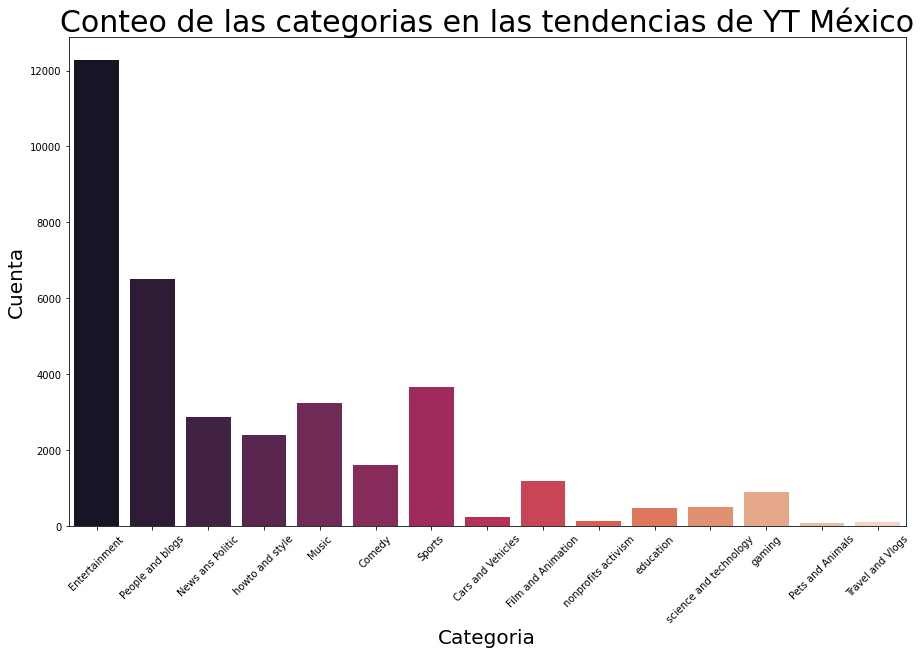

In [148]:
plt.rcParams['figure.figsize'] = (15, 9)
plt.style.use('tableau-colorblind10')

sns.countplot(dfym['categoria'], palette = 'rocket')

plt.title('Conteo de las categorias en las tendencias de YT México', fontweight = 30, fontsize = 30)
plt.xlabel('Categoria',fontsize = 20)
plt.ylabel('Cuenta',fontsize = 20)
plt.xticks(rotation = 45)
plt.show()

**Palabras mas usadas en el titulo, descripcion y titulo+descripcion de tendencias de YT México**

Obtendremos las palabras mas usadas en la columna de titulo por razones de graficacion solo contaremos las 10 palabras mas usadas para cada columna

**Titulo**

In [ ]:
Words = []
for oracion in dfym.titulo:
    words = oracion.split() 
    for j in range(len(words)):
        Words.append(words[j])
frecuencia = Counter(Words)
df = pd.DataFrame.from_dict(frecuencia, orient='index').reset_index()
frecuentes = df.sort_values(0, ascending = False)
mas_frecuentes = frecuentes.head(10)

In [ ]:
feature_names = mas_frecuentes["index"].tolist()
repetido = mas_frecuentes[0].tolist()

Text(0, 0.5, 'Variables')

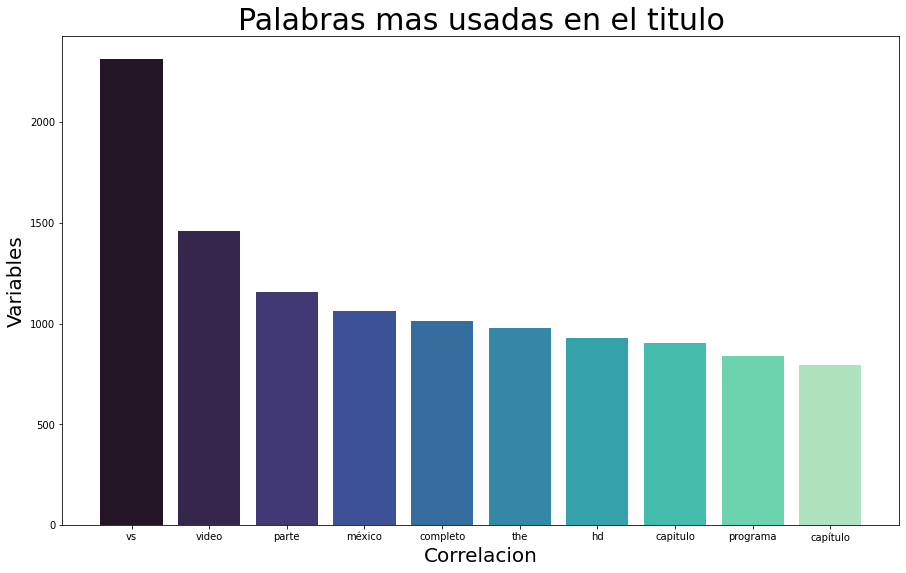

In [ ]:
feature_names = mas_frecuentes["index"]
plt.bar(feature_names,repetido, color = sns.color_palette("mako",len(feature_names)))
plt.title('Palabras mas usadas en el titulo', fontweight = 30, fontsize = 30)
plt.xlabel('Correlacion',fontsize = 20)
plt.ylabel('Variables',fontsize = 20)

**Descripcion**

In [ ]:
Words = []
for oracion in dfym.descripcion:
    words = oracion.split() 
    for j in range(len(words)):
        Words.append(words[j])
frecuencia = Counter(Words)
df = pd.DataFrame.from_dict(frecuencia, orient='index').reset_index()
frecuentes = df.sort_values(0, ascending = False)
mas_frecuentes = frecuentes.head(10)

In [ ]:
feature_names = mas_frecuentes["index"].tolist()
repetido = mas_frecuentes[0].tolist()

Text(0, 0.5, 'Veces que se uso')

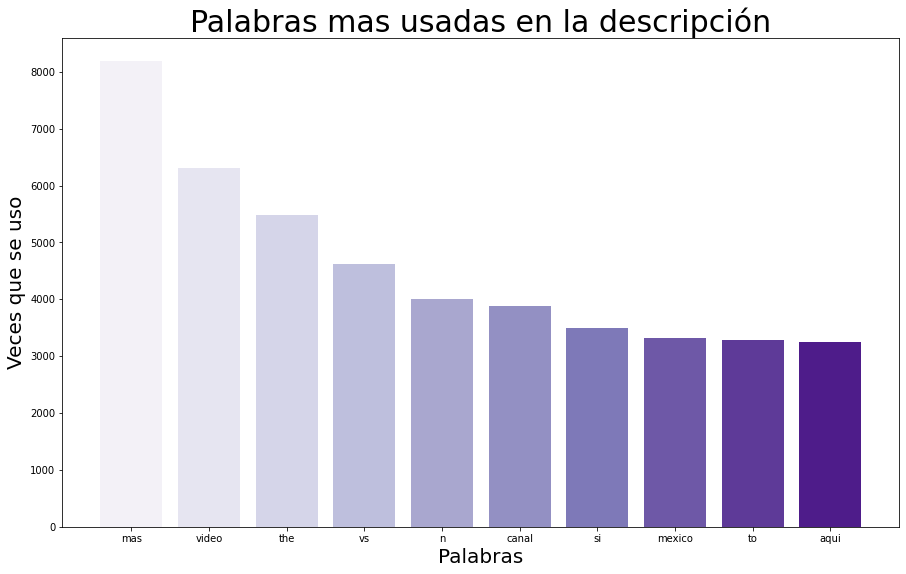

In [ ]:
feature_names = mas_frecuentes["index"]
plt.bar(feature_names,repetido, color = sns.color_palette("Purples",len(feature_names)))
plt.title('Palabras mas usadas en la descripción', fontweight = 30, fontsize = 30)
plt.xlabel('Palabras',fontsize = 20)
plt.ylabel('Veces que se uso',fontsize = 20)

**Descripcion + Titulo**

In [ ]:
Words = []
for oracion in dfym["Titulo + Descripcion"]:
    words = oracion.split() 
    for j in range(len(words)):
        Words.append(words[j])
frecuencia = Counter(Words)
df = pd.DataFrame.from_dict(frecuencia, orient='index').reset_index()
frecuentes = df.sort_values(0, ascending = False)
mas_frecuentes = frecuentes.head(10)

In [ ]:
feature_names = mas_frecuentes["index"].tolist()
repetido = mas_frecuentes[0].tolist()

Text(0, 0.5, 'Veces que se uso')

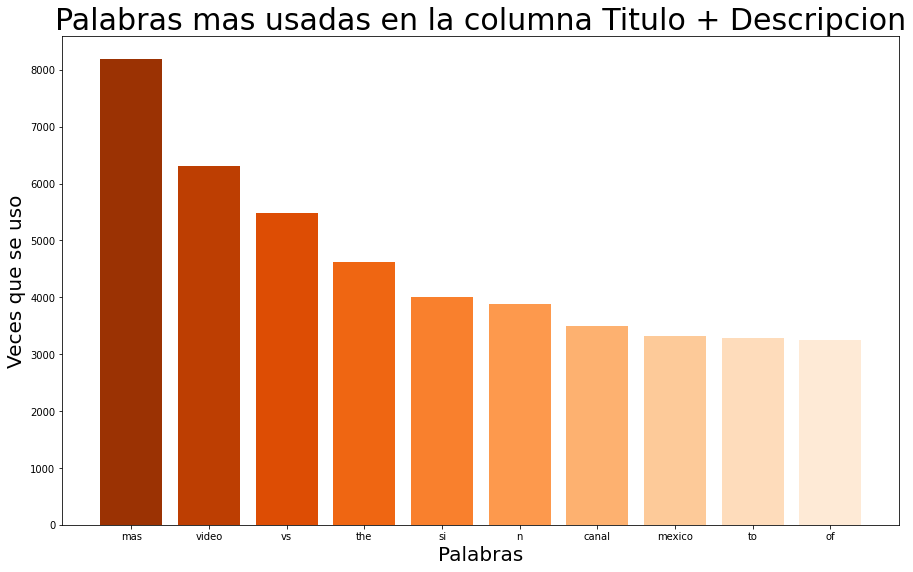

In [ ]:
feature_names = mas_frecuentes["index"]
plt.bar(feature_names,repetido, color = sns.color_palette("Oranges_r",len(feature_names)))
plt.title('Palabras mas usadas en la columna Titulo + Descripcion', fontweight = 30, fontsize = 30)
plt.xlabel('Palabras',fontsize = 20)
plt.ylabel('Veces que se uso',fontsize = 20)

### Probando Modelo de Clasificacion con ejemplo simple(Multinomial Naive Bayes)

Aplicare el clasificador multinomial al df de tendencias de youtube para poder observar que tan bueno es el clasificador,
lo implementare utilizando el titulo, la descripcion y finalmente el titulo mas la descripcion para ver cual obtiene los mejores resultados, tanto el titulo como la descripcion seran la variable X y la variable Y o variable dependiente seran las categorias de youtube de esa forma en base a las caracteristicas de X sera el valor de Y, es lo que hara el modelo

**Probando NV con la combinacion de titulo y descripcion**

In [149]:
#Eliminamos los valores nulos ya que si los hay no funcionara el clasificador 
dfym = dfym.dropna()

In [ ]:
#biblioteca que divide el conjunto de datos en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
#extrae las caracteristicas
from sklearn.feature_extraction.text import TfidfVectorizer
#extrae las caracteristicas y vectoriza estas
from sklearn.feature_extraction.text import CountVectorizer
#importamos el modelo a utilizar
from sklearn.naive_bayes import MultinomialNB
#biblioteca para calcular metricas
from sklearn.metrics import accuracy_score

**Probando NV con Titulo + Descripción**

Una vez que hemos importado las bibliotecas necesarias implementaremos el modelo lo primero que hay que hacer es crear tanto el conjunto de entrenamiento como el conjunto de prueba para eso como ya mencionamos la variable X sera la columna de descripcion mas titulo y la variable Y sera la categoria. Asignamos el 80% de los datos para entrenar el modelo y 20% para probar el modelo.

In [ ]:
#Definimos el metodo a utilizar que es vectorizar las caracteristicas en base a n gramas de 1 y dos de longitud 
cv = CountVectorizer(max_features=10000, ngram_range=(1,2))
#tranformamos a la columna de titulo + descripcion en caracteristicas vectorizadas
X = cv.fit_transform(dfym["Titulo + Descripcion"]).toarray()
#asignamos a Y los valores presentes en la columna de categoria 
y = dfym['categoria'].values
#Definimos el conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
#definimos el modelo
nb_classifier = MultinomialNB()
#entrenamos el modelo 
nb_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
#probamos el modelo 
nb_y_pred = nb_classifier.predict(X_test)

In [ ]:
#calculamos la eficacioa del modelo
score = accuracy_score(y_test, nb_y_pred)
score = score*100
score

65.87991718426501

**Probando NV con el titulo**

In [ ]:
#Definimos el metodo a utilizar que es vectorizar las caracteristicas en base a n gramas de 1 y dos de longitud 
cv = CountVectorizer(max_features=10000, ngram_range=(1,2))
#tranformamos a la columna de descripcion en caracteristicas vectorizadas
X = cv.fit_transform(dfym["titulo"]).toarray()
#asignamos a Y los valores presentes en la columna de categoria 
y = dfym['categoria'].values
#Definimos el conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
#definimos el modelo
nb_classifier = MultinomialNB()
#entrenamos el modelo 
nb_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
 #probamos el modelo 
 nb_y_pred = nb_classifier.predict(X_test)

In [ ]:
#calculamos eficacio del modelo 
score = accuracy_score(y_test, nb_y_pred)
score = score*100
score

66.87370600414079

**Probando NV con la descripcion**

In [ ]:
#Definimos el metodo a utilizar que es vectorizar las caracteristicas en base a n gramas de 1 y dos de longitud 
cv = CountVectorizer(max_features=10000, ngram_range=(1,2))
#tranformamos a la columna de descripcion en caracteristicas vectorizadas
X = cv.fit_transform(dfym["descripcion"]).toarray()
#asignamos a Y los valores presentes en la columna de categoria 
y = dfym['categoria'].values
#Definimos el conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
#definimos el modelo 
nb_classifier = MultinomialNB()
#entrenamos el modelo 
nb_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
#probamos el modelo 
nb_y_pred = nb_classifier.predict(X_test)

In [ ]:
#calculamos la eficacia del modelo 
score = accuracy_score(y_test, nb_y_pred)
score = score*100
score

62.056590752242926

<BarContainer object of 3 artists>

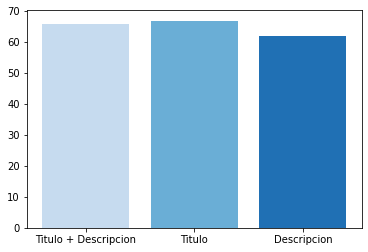

In [ ]:
modelos = ["Titulo + Descripcion","Titulo", "Descripcion"]
scores = [65.87991718426501,66.87370600414079,62.056590752242926]
plt.bar(modelos,scores, color = sns.color_palette("Blues",len(modelos)))

Como podemos observar al igual que su homologo de tendencias de YouTube USA, los modelos de naive bayes entrenados con las tendencias de México no difieren entre usar titulo, titulo + descripcion, descripcion pero en lo que si difieren es que el modelo entrenado solo con el titulo presento mejores resultados que el modelo de titulo + descripcion mientras que en el de tendencias USA fue al reves.
La diferencia mas importante es que los modelo de tendencias de USA para clasificacion fueron mucho mas efectivos que los de tendencias mexico con una diferencia de efectividad de aproximadamente un 20% mas eficaces lo que podria atribuirse principalmente a que en el modelo de tendencias de USA esta lemmatizado, lo que provoca que la extraccion de caracteristicas a la hora de entrenar los modelos sea mejor ya que se eliminan las variaciones.

## Utilizando el traductor para intentar mejorar el modelo 

Derivado de los resultados mas bajos obtenidos por el modelo de clasificacion para las tendencias en México y por lo tanto en español decidi traducir las palabras para de esa forma despues poder lemmatizarlas y que los resultados fueron tan buenos como lo son en el modelo entrenado con palabras en inglés.

In [ ]:
#aplicamos la funcion de traduccion para la columna de titulo 
dfym["titulo"] = traductor(dfym["titulo"])
#reemplazamos la columna por la columna ya traducida
dfym["titulo"]= dfym.titulo.map(lambda x: ' '.join(x))

In [ ]:
#aplicamos el metodo de traduccion para la columna de descripcion
dfym["descripcion"] = traductor(dfym["descripcion"])
#sustituimos columna
dfym["descripcion"]= dfym.descripcion.map(lambda x: ' '.join(x))

In [ ]:
#obtenemos una nueva columna de titulo + descripcion pero ahora ya con las columnas traducidas
dfym["Titulo + Descripcion"] = dfym["titulo"] + " " + dfym["descripcion"]

In [ ]:
dfym.head(3)

,titulo,descripcion,fecha,categoria,Titulo + Descripcion
0,chapter masterchef,enjoy él presence del chef torreblanca en mast...,2017-11-13T06:06:22.000Z,Entertainment,chapter masterchef enjoy él presence del chef ...
1,alexa ex Integrant del group timbiriche discla...,alexa exintegrante del group timbiriche discla...,2017-11-13T05:11:58.000Z,People and blogs,alexa ex Integrant del group timbiriche discla...
2,louis The ledge the pulse of he republic,él song del principle él call east spirit de o...,2017-11-13T17:00:02.000Z,News ans Politic,louis The ledge the pulse of he republic él so...


### Probando el modelo despues de traducir las palabras

**Probando NV con la descripcion + el titulo traducidos**

In [ ]:
cv = CountVectorizer(max_features=10000, ngram_range=(1,2))
X = cv.fit_transform(dfym["Titulo + Descripcion"]).toarray()
y = dfym['categoria'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
nb_y_pred = nb_classifier.predict(X_test)

In [ ]:
score = accuracy_score(y_test, nb_y_pred)
score = score*100
score

39.58333333333333

**Probando con la descripción traducida**

In [ ]:
cv = CountVectorizer(max_features=10000, ngram_range=(1,2))
X = cv.fit_transform(dfym["descripcion"]).toarray()
y = dfym['categoria'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
nb_y_pred = nb_classifier.predict(X_test)

In [ ]:
score = accuracy_score(y_test, nb_y_pred)
score = score*100
score

41.66666666666667

**Probando el modelo NV con el titulo traducido**

In [ ]:
cv = CountVectorizer(max_features=10000, ngram_range=(1,2))
X = cv.fit_transform(dfym["titulo"]).toarray()
y = dfym['categoria'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
nb_y_pred = nb_classifier.predict(X_test)

In [ ]:
score = accuracy_score(y_test, nb_y_pred)
score = score*100
score

41.66666666666667

Como podemos observar el hecho de traducir el modelo no mejoro las predicciones de este si no todo lo contrario las empeoro y esto puede ser a la mala traducción lo que a su vez afecto la lemmatizacion de las palabras agravando aun mas el problema de extraccion de caracteristicas, causando que  el modelo se viera afectado por lo que optare por seguir usando el conjunto de datos sin traducir, enfocandome en la columna Titulo + Descripcion ya que fue la que mejores resultados presento 

# Crimen en la CDMX

El DF de crimen en la cdmx fue sacado de la secretaria de seguridad ciudadana de la cdmx y contiene los delitos en la ciudad de mexico durante 2017 y 2018, cuenta con 479923 renglones es decir cuenta con la descripcion de 479923 delitos afectuados en la ciudad de México descritos en 18 columnas como delito, fecha en que se efectuo el delito, delegacion donde se efectuo el delito, hora en que se efectuo el delito, coordenadas exactas del delito, etc.

In [150]:
m_crimen = pd.read_csv("carpetas-de-investigacion-pgj-de-la-ciudad-de-mexico.csv")

In [151]:
m_crimen.head(3)

,ao_hechos,mes_hechos,fecha_hechos,delito,categoria_delito,fiscalia,agencia,unidad_investigacion,alcaldia_hechos,colonia_hechos,ao_inicio,mes_inicio,fecha_inicio,calle_hechos,calle_hechos2,longitud,latitud,geopoint
0,2017,Enero,2017-01-01 23:00:00,DENUNCIA DE HECHOS,HECHO NO DELICTIVO,INVESTIGACIÓN PARA LA ATENCIÓN DE DELITOS SEXU...,FDS-2,FDS-2-01,NaN,NaN,2016,Enero,2016-01-05 10:52:34,HECHOS EN EL ESTADO DE SAN LUIS POTOSI,NaN,NaN,NaN,NaN
1,2017,Septiembre,2017-09-24 11:00:00,PRIVACION DE LA LIBERTAD PERSONAL,DELITO DE BAJO IMPACTO,INVESTIGACIÓN EN MIGUEL HIDALGO,MH-1,UI-1SD,MIGUEL HIDALGO,TORRE BLANCA,2017,Octubre,2017-10-02 20:32:50,CALZ. LEGARIA,NaN,-99.195281,19.455773,"19.4557725806,-99.1952812055"
2,2017,Septiembre,2017-09-28 13:30:00,AMENAZAS,DELITO DE BAJO IMPACTO,INVESTIGACIÓN EN AZCAPOTZALCO,AZ-1,UI-1SD,AZCAPOTZALCO,LIBERACIÓN,2017,Octubre,2017-10-02 20:37:26,CALLE 7,12,-99.152178,19.471574,"19.471574024,-99.1521783739"


In [152]:
m_crimen.isnull().sum()

ao_hechos                    0
mes_hechos                   0
fecha_hechos                 0
delito                       0
categoria_delito             0
fiscalia                     0
agencia                      0
unidad_investigacion         0
alcaldia_hechos           2487
colonia_hechos           19170
ao_inicio                    0
mes_inicio                   0
fecha_inicio                 0
calle_hechos              1424
calle_hechos2           291165
longitud                 18522
latitud                  18522
geopoint                 18522
dtype: int64

In [153]:
m_crimen["delito"].value_counts().sum()

479923

### Preprocesamiento de los datos

Lo primero para iniciar con el procesamiento de los datos es obtener las columnas de interes para nuestro estudio, por lo que primero cree un dataframe nuevo solo con las columnas de interes para nuestro estudio

In [154]:
dfcd = pd.DataFrame()
dfcd["delito"] = m_crimen["delito"]
dfcd["fecha"] = m_crimen["fecha_hechos"]
dfcd["alcaldia"] = m_crimen["alcaldia_hechos"]

In [155]:
dfcd["delito"] = limpieza(dfcd["delito"])

In [156]:
dfcd.head(5)

,delito,fecha,alcaldia
0,denuncia hechos,2017-01-01 23:00:00,NaN
1,privacion libertad personal,2017-09-24 11:00:00,MIGUEL HIDALGO
2,amenazas,2017-09-28 13:30:00,AZCAPOTZALCO
3,robo objetos,2017-08-15 12:00:00,ALVARO OBREGON
4,robo objetos,2017-10-02 17:30:00,MIGUEL HIDALGO


Informacion de los indices delictivos de cdmx

In [157]:
df = dfcd.delito.value_counts().rename_axis('unique_values').reset_index(name='counts')
delitos = df.unique_values.tolist()
n_delitos = df.counts.tolist()

In [158]:
len(delitos)

271

In [159]:
mas_frecuentes = df.unique_values.head(15).tolist()
val_frecuentes = df.counts.head(15).tolist()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text major ticklabel objects>)

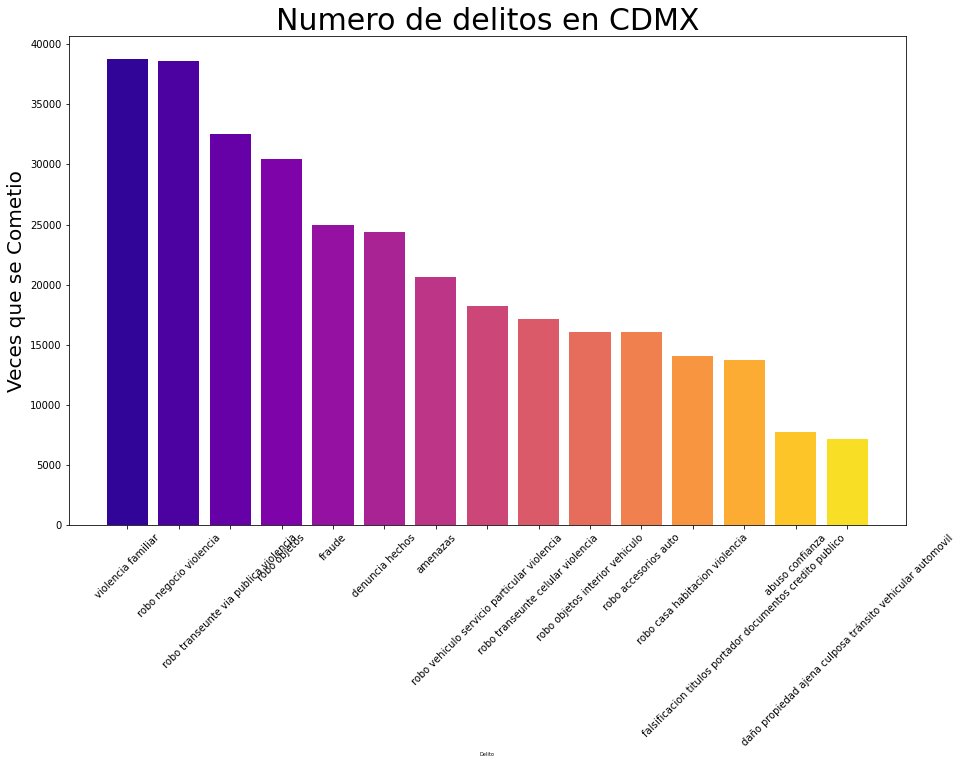

In [160]:
plt.bar(mas_frecuentes,val_frecuentes, color = sns.color_palette("plasma",len(mas_frecuentes)))
plt.title('Numero de delitos en CDMX', fontweight = 30, fontsize = 30)
plt.xlabel('Delito',fontsize = 5)
plt.ylabel('Veces que se Cometio',fontsize = 20)
plt.xticks(rotation = 45)

### Obtener el delito mas común por día
Tenemso mas de 479923 delitos los cuales fueron cometidos a lo largo de multiples dias y se cometieron varios delitos durante los diferentes dias por lo que sumare todos los delitos de un mismo dia y obtendre el mas comun

In [161]:
#Primero obtenemos las fechas unicas de nuestro set de datos, es decir los dias unicos en que se cometio un delito ya que existen
#varios delitos en el mismo dia
fechas = list(dfcd["fecha"].unique())
len(fechas)

159157

**Corregir la fecha**

Como vimos en la seccion anterior tenemos muchas fechas unicas y esto se debe a que el dato de fecha incluye la hora lo cual aumenta el numero de fechas unicas a tratar, corregi el formato de esta para de esa forma tener un formato que sea mas facil de trabajar y que ademas coincida con el de los videos de YouTube

In [162]:
#Obtenemos la columna de fechas de nuestra df para poder trabajar con el 
fechas_a_corregir = list(dfcd["fecha"])

In [163]:
#lista donde se guardaran las fechas corregidas
fecha_corregida = []
#iteramos sobre cada fecha del df que vamos a corregir
for i in fechas_a_corregir:
    #el año son los 4 primeros digitos de la fecha
    año = i[:4]
    #el mes se encuentra entre el 5-7 valor de la cadena
    mes = i[5:7]
    #el dia son el caracter 8 al 10 
    dia = i[8:10]
    #Solo conservamos año, mes y fecha ya que los otros datos no 
    #son de gran interes para nosotros 
    #le damos el formato ademas de sustituir los guiones por diagonales
    fecha = año+"/"+mes+"/"+dia
    #llenamos la lista de fechas corregidas con cada fecha corregida 
    #que obtenemos del ciclo for 
    fecha_corregida.append(fecha)

In [164]:
#reemplazamos los valores de la fecha por los de nuestras fechas corregidas 
dfcd["fecha"] = fecha_corregida

In [165]:
#observamos que ahora la fecha tiene un valor mas facil de manejar
dfcd.head(1)

,delito,fecha,alcaldia
0,denuncia hechos,2017/01/01,NaN


In [166]:
#Ahora que hemos corregido las fechas obtenemos las fechas unicas
fechas = list(dfcd["fecha"].unique())
len(fechas)

730

Observamos que tenemos 730 fechas diferentes es decir tenemos los delitos de exactamente dos años, ahora que ya tenemos las fechas en que se cometieron los dias, promediaremos los delitos de un dia y obtendremos el delito mas comun por dia 

In [167]:
#lista que guardara la fecha del delito
fecha_delito = []
#lista con los delitos mas comunes por dia 
delito_dia = []
#iteramos cada fecha unica es decir cada dia de los dos que tenemos
for fecha in fechas:
    #se llena con el dia sobre el cual se hace la operacion 730 en total
    fecha_delito.append(fecha)
    #la varibale a obtiene todas las filas que coinciden con el dia que estamos iterando
    #en otras palabras creamos un submarco de datos solo con los datos de la fecha que iteramos
    a = dfcd[dfcd["fecha"]== fecha]
    #la variable b obtiene los delitos del subconjunto de marcos creado con a y la convierte en 
    #una lista y cuenta la frecuancia en la que aparece cada lista
    b = Counter((list(a["delito"])))
    #c obtiene el valor maximo es decir el delito mas frecuente sin embargo solo obtiene un numero 
    #pero no podriamos saber que delito es el mas comun
    c = max(b.values())
    #la variable moda corresponde a encontrar el valor de lista mas repetido 
    moda = {key for key, count in b.items() if count == c}
    #llenamos la lista de los delitos mas comunes por dia
    delito_dia.append(moda)

In [168]:
#Obtenemos el tipo de los elementos de nuestra lista de delitos mas comunes 
type(delito_dia[0])

set

In [169]:
#Si bien tenemos el delito mas comun por dia en una lista cada elemento de esta lista es un objeto del tipo
#set por lo que tenemos que convertirlo en una cadena del tipo string de esa forma es mas facil trabajar con el 
delito_comun=[]
for i in range(0,len(delito_dia)):
    a_set = delito_dia[i]
    list_of_strings = [str(s) for s in a_set]
    joined_string = " ".join(list_of_strings)
    delito_comun.append(joined_string)

In [170]:
#Comprobamos que ya los elementos son del tipo string
type(delito_comun[0])

str

**Creamos un nuevo dataframe solo con los delitos mas comunes y su fecha correspondiente**

In [171]:
cd_del= pd.DataFrame(delito_comun, columns = ['Crimen'])
cd_del["fecha"]=fecha_delito

In [172]:
cd_del.head(3)

,Crimen,fecha
0,violencia familiar,2017/01/01
1,violencia familiar,2017/09/24
2,violencia familiar,2017/09/28


Como podemos observar ya tenemos un conjunto de datos con 730 fechas diferentes y el delito mas comun que se realizo ese dia 

### Unir los conjuntos de datos para entrenar el modelo
Ya que obtuvimos los delitos mas comunes por dia tenemos que unir nuestro conjunto de datos de youtube con nuestro conjunto de datos de crimen en la cdmx para de esa forma asignar un delito a cada video tendencia de youtube en mexico y entrenar un modelos 

In [173]:
dfym.head(3)

,titulo,descripcion,fecha,categoria,Titulo + Descripcion
0,capítulo masterchef,disfruta presencia chef torreblanca masterchef...,2017-11-13T06:06:22.000Z,Entertainment,capítulo masterchef disfruta presencia chef to...
1,alexa exintegrante grupo timbiriche renuncia v...,alexa exintegrante grupo timbiriche renuncia v...,2017-11-13T05:11:58.000Z,People and blogs,alexa exintegrante grupo timbiriche renuncia v...
2,louis ckagó pulso república,cancion principio llama espiritu carnales carn...,2017-11-13T17:00:02.000Z,News ans Politic,louis ckagó pulso república cancion principio ...


Uniremos los conjuntos de datos mediante la fecha por lo que las fechas por lo que el formato de estas deben coincidir en los dos conjuntos de datos como anteriomente hicimos con las fechas de delitos en la cdmx procederemos ha hacer lo mismo.

In [175]:
lista = list(dfym["fecha"].astype(str))

In [176]:
#Obtenemos la columna de fechas de nuestra df para poder trabajar con el 
fechas_a_corregir = lista
#lista donde se guardaran las fechas corregidas
fecha_corregida = []
#iteramos sobre cada fecha del df que vamos a corregir
for i in fechas_a_corregir:
    #el año son los 4 primeros digitos de la fecha
    año = i[:4]
    #el mes se encuentra entre el 5-7 valor de la cadena
    mes = i[5:7]
    #el dia son el caracter 8 al 10 
    dia = i[8:10]
    #Solo conservamos año, mes y fecha ya que los otros datos no 
    #son de gran interes para nosotros 
    #le damos el formato ademas de sustituir los guiones por diagonales
    fecha = año+"/"+mes+"/"+dia
    #llenamos la lista de fechas corregidas con cada fecha corregida 
    #que obtenemos del ciclo for 
    fecha_corregida.append(fecha)


In [177]:
#reemplazamos los valores de la fecha por los de nuestras fechas corregidas 
dfym["fecha"] = fecha_corregida

In [178]:
dfym.head(3)

,titulo,descripcion,fecha,categoria,Titulo + Descripcion
0,capítulo masterchef,disfruta presencia chef torreblanca masterchef...,2017/11/13,Entertainment,capítulo masterchef disfruta presencia chef to...
1,alexa exintegrante grupo timbiriche renuncia v...,alexa exintegrante grupo timbiriche renuncia v...,2017/11/13,People and blogs,alexa exintegrante grupo timbiriche renuncia v...
2,louis ckagó pulso república,cancion principio llama espiritu carnales carn...,2017/11/13,News ans Politic,louis ckagó pulso república cancion principio ...


In [179]:
#Ahora que hemos corregido las fechas obtenemos las fechas unicas
fechas = list(dfym["fecha"].unique())
len(fechas)

249

Observamos que tenemos solo 249 dias con sus respectivas tendencias por lo que varia con el numero de fechas de delitos que tenemos lo cual no es ningun problema por el contrario es una buena noticia ya que al tener mas fechas en delitos y menos en tendencias de youtube lo mas probable es que las fechas que estan en tendencias tambien esten en youtube por lo que de esa forma la mayoria de las tendencias tendra un delito asignado 

**Crear diccionario**

Crearemos un diccionario basado en el df de el delito mas comun por dia de esa forma las llaves de nuestro diccionario seran las fechas y su valor los delitos asi podremos darle el delito mas comun a cada tendencia de youtube deacuerdo a el dia 

In [180]:
#Para la creacion del diccionario apartir de un df primero colocamos la columna que contiene los valores que seran 
#llave seguido de la columa que tiene  los valores
cd_dicc =cd_del.set_index('fecha')['Crimen'].to_dict()

In [181]:
len(dfym)

36224

**Unir DataFrames**

Ya con el diccionario y con la fecha corregida en el conjunto de datos de youtube ahora procederemos a asignar un delito mas comun a cada video de tendencia.

In [182]:
dfym.isnull().sum()

titulo                  0
descripcion             0
fecha                   0
categoria               0
Titulo + Descripcion    0
dtype: int64

Observamos que no hay valores nulos lo cual es bueno sin embargo paradojicamente lo que haremos sera crear un columna de delito con solo valores nan

In [185]:
dfym["delito"] = np.nan

Una vez que tenemos la columna de delitos con valores NaN lo que haremos sera reemplazar el valor de cada linea de esa columna mediante el diccionario de delitos mas comunes tomando en cuenta la fecha que posee esa linea y usarla como llave para tener un valor en el diccionario

In [186]:
#lista donde se almacenan fechas
fechas = []
#contador que itera sobre el indice de las lineas del dataframe
contador = 0;
#iteramos sobra cada linea de fecha de nuestro set de datos
for fecha in dfym["fecha"]:
  #una vez que obtenemos la fecha verificamos si esta en el diccionario
    if fecha in cd_dicc.keys():
        #si lo esta la usamos como llave y obtenemos un valor
        delito = cd_dicc[fecha]
        #asignamos ese valor al indice de la linea que marca nuestro contador
        dfym["delito"].iloc[contador] = delito 

        fechas.append(delito)
    #aumentamos el contador
    contador += 1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [187]:
dfym.isnull().sum()

titulo                   0
descripcion              0
fecha                    0
categoria                0
Titulo + Descripcion     0
delito                  18
dtype: int64

Verificamos nuestro DF y observamos que este fue llenado de forma excelente solo 20 casillas de fecha no se encontraron en en el diccionario por lo cual procederemos a eliminarlas ya que son fechas con valores atipicos como una tendencia del 2006 o una del 2007 y dado que nuestro rango de estudio es 2018 y 2017 eliminarlas es lo mejor y tomando en cuenta que son solo 18 lineas de mas de 40 mil el modelo no tiene por que verse afectado 

In [188]:
dfym = dfym.dropna()

In [190]:
dfym.isnull().sum()

titulo                  0
descripcion             0
fecha                   0
categoria               0
Titulo + Descripcion    0
delito                  0
dtype: int64

Observamos que ahora ya tenemos un conjunto de datos mixto que une el set de crimen de la cdmx con el de tendencias de youtube en donde cada tendencia tiene un crimen asociado de esa forma podremos abordar un tema de clasificacion en el que en base a los atributos de titulo y descripcion el modelo intentara clasificar un delito 

In [191]:
dfym.head(3)

,titulo,descripcion,fecha,categoria,Titulo + Descripcion,delito
0,capítulo masterchef,disfruta presencia chef torreblanca masterchef...,2017/11/13,Entertainment,capítulo masterchef disfruta presencia chef to...,violencia familiar
1,alexa exintegrante grupo timbiriche renuncia v...,alexa exintegrante grupo timbiriche renuncia v...,2017/11/13,People and blogs,alexa exintegrante grupo timbiriche renuncia v...,violencia familiar
2,louis ckagó pulso república,cancion principio llama espiritu carnales carn...,2017/11/13,News ans Politic,louis ckagó pulso república cancion principio ...,violencia familiar


#Obteneiendo informacion de los datos de crimen en cdmx

**Delitos mas comunes por categoria**

In [198]:
graficar = pd.DataFrame()


In [201]:
graficar["categoria"] = dfym.categoria.unique()
graficar["robo transeunte via publica violencia"] = np.nan
graficar['violencia familiar'] = np.nan
graficar['robo negocio violencia'] = np.nan
graficar['robo transeunte celular violencia'] = np.nan
graficar['fraude'] = np.nan
graficar['robo objetos'] = np.nan
cuenta = dfym[dfym.delito == "robo transeunte via publica violencia"]
cuenta1 = dfym[dfym.delito == 'violencia familiar']
cuenta2 = dfym[dfym.delito == 'robo negocio violencia']
cuenta3 = dfym[dfym.delito == 'robo transeunte celular violencia']
cuenta4 = dfym[dfym.delito == 'fraude']
cuenta5 = dfym[dfym.delito == 'robo objetos']

In [234]:
#colocamos el numero de cuenta que queremos segun el delito 
cuenta5.categoria.value_counts()
df = cuenta5.categoria.value_counts().rename_axis('unique_values').reset_index(name='counts')


In [235]:
ny_dicc =df.set_index('unique_values')['counts'].to_dict()

In [236]:
contador = 0;
for i in graficar["categoria"]:
    if i in ny_dicc.keys():
        #intercambiamos el nombre de la columna segun el que queramos llenar
        graficar['robo objetos'][contador] = ny_dicc[i]
    contador += 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [237]:
graficar.head(3)

,categoria,robo transeunte via publica violencia,violencia familiar,robo negocio violencia,robo transeunte celular violencia,fraude,robo objetos
0,Entertainment,4384.0,3163.0,2740.0,866.0,337.0,336.0
1,People and blogs,2228.0,1713.0,1451.0,483.0,176.0,198.0
2,News ans Politic,1281.0,625.0,528.0,159.0,82.0,70.0


In [238]:
graficar = pd.DataFrame(graficar)

Text(0.5, 1.0, 'Relacion Delito-Categoria')

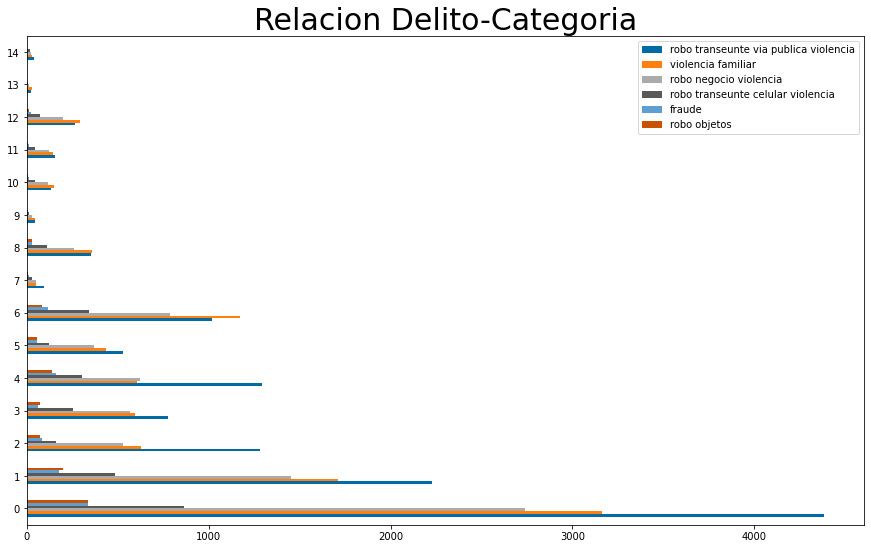

In [239]:
graficar.plot(kind = 'barh')
plt.title('Relacion Delito-Categoria', fontweight = 30, fontsize = 30)

**Dias con mas delitos**

In [240]:
df = dfym.fecha.value_counts().rename_axis('dias').reset_index(name='cuenta')
comunes = df.head(15)

In [241]:
dia_co = comunes.dias.tolist()
cuent = comunes.cuenta.tolist()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text major ticklabel objects>)

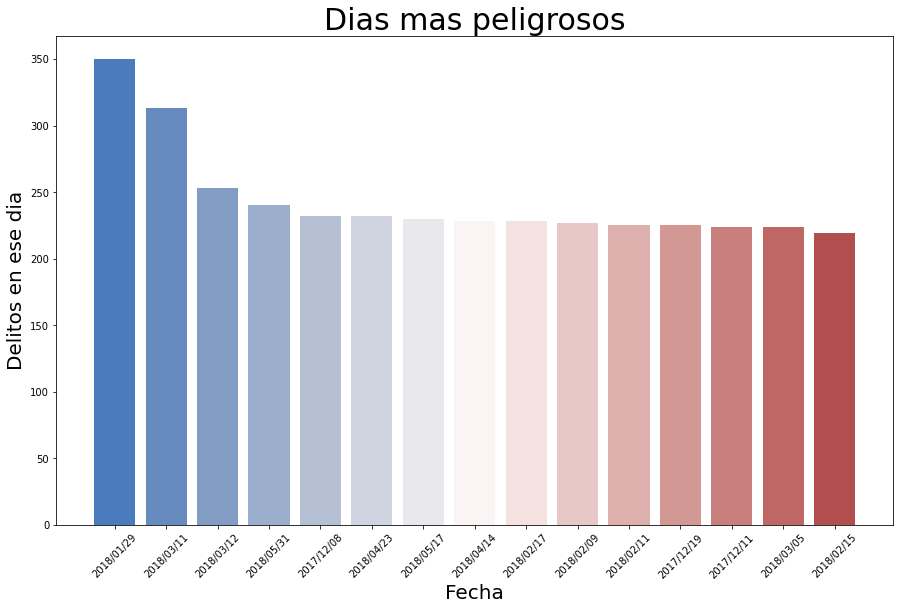

In [246]:
plt.bar(dia_co,cuent, color = sns.color_palette("vlag",len(dia_co)))
plt.title('Dias mas peligrosos', fontweight = 30, fontsize = 30)
plt.xlabel('Fecha',fontsize = 20)
plt.ylabel('Delitos en ese dia',fontsize = 20)
plt.xticks(rotation = 45)

## Palabra mas comun por crimen

In [249]:
dfym.delito.value_counts()

robo transeunte via publica violencia                           12610
violencia familiar                                               9404
robo negocio violencia                                           7869
robo transeunte celular violencia                                2857
fraude                                                           1083
robo objetos                                                     1017
robo transeunte via publica violencia robo negocio violencia      606
violencia familiar robo negocio violencia                         226
violencia familiar robo transeunte via publica violencia          211
robo transeunte celular violencia robo negocio violencia          164
violencia familiar robo objetos                                   157
denuncia hechos                                                     1
robo transeunte celular violencia violencia familiar                1
Name: delito, dtype: int64

robo transeunte via publica violencia

In [253]:
robo = dfym[dfym.delito=="robo transeunte via publica violencia"]
text = " ".join(frase for frase in robo["Titulo + Descripcion"])

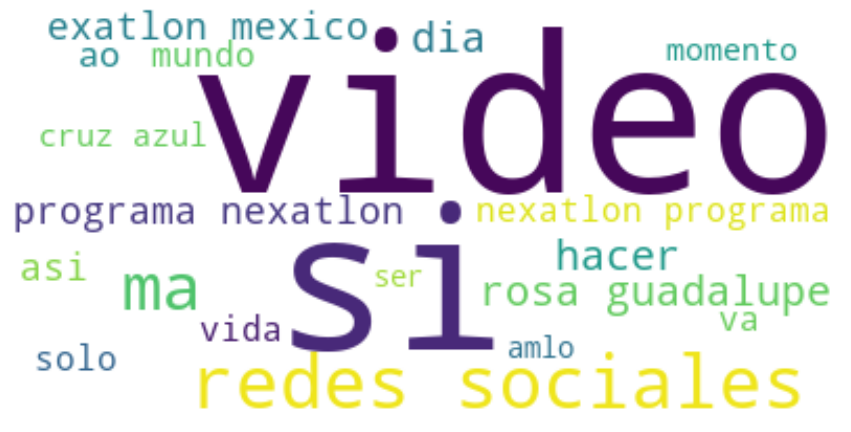

In [254]:
wordcloud = WordCloud( max_words=20, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

violencia familiar

In [255]:
robo = dfym[dfym.delito=="violencia familiar"]
text = " ".join(frase for frase in robo["Titulo + Descripcion"])

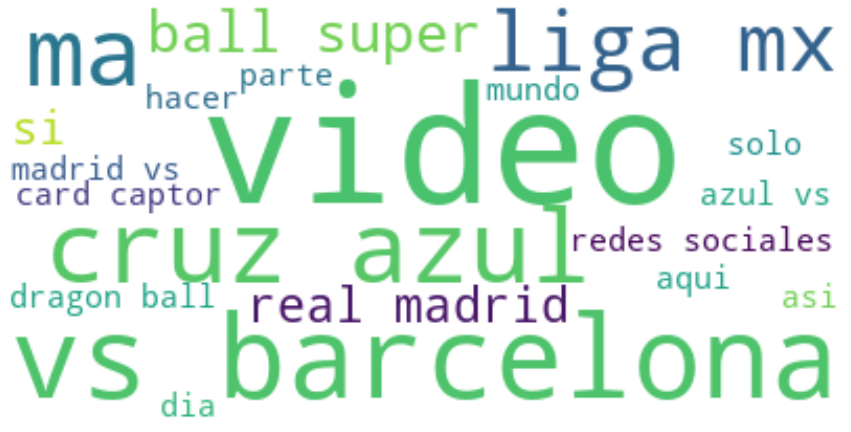

In [256]:
wordcloud = WordCloud( max_words=20, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

robo negocio violencia

In [257]:
robo = dfym[dfym.delito=="robo negocio violencia"]
text = " ".join(frase for frase in robo["Titulo + Descripcion"])

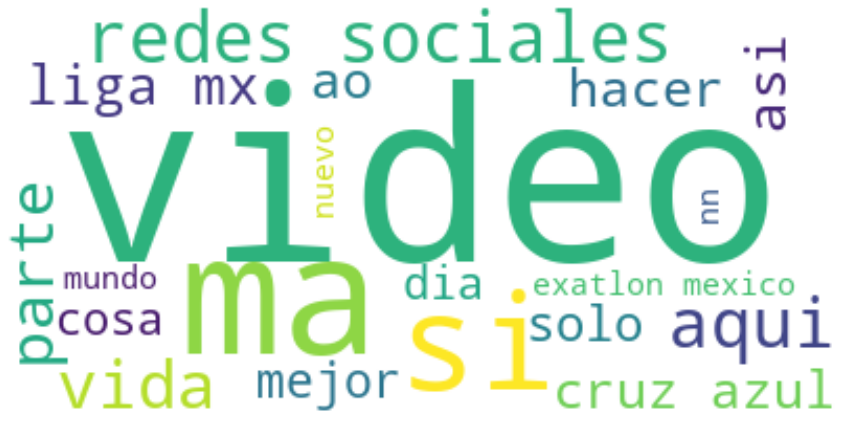

In [258]:
wordcloud = WordCloud( max_words=20, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

robo transeunte celular violencia

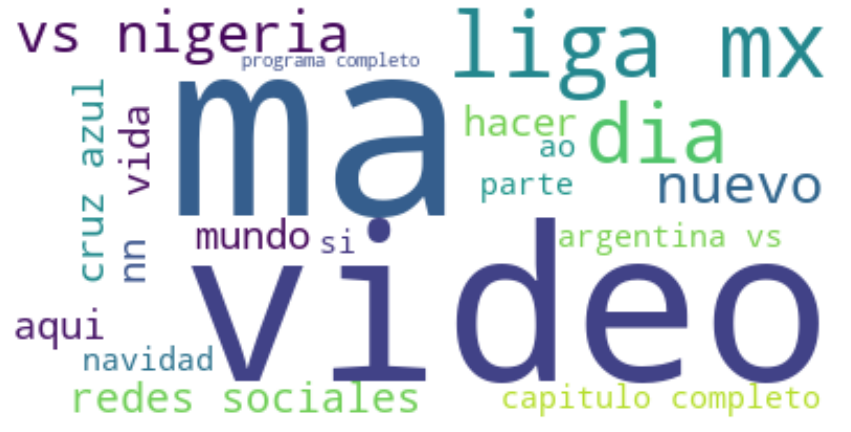

In [259]:
robo = dfym[dfym.delito=="robo transeunte celular violencia"]
text = " ".join(frase for frase in robo["Titulo + Descripcion"])
wordcloud = WordCloud( max_words=20, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

fraude

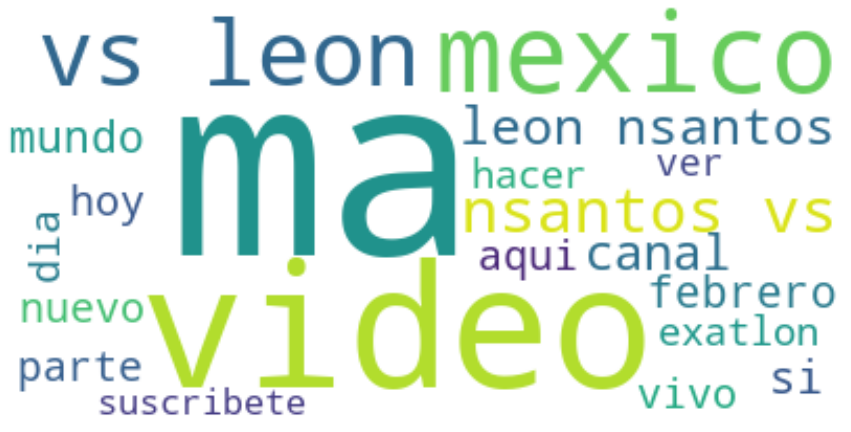

In [260]:
robo = dfym[dfym.delito=="fraude"]
text = " ".join(frase for frase in robo["Titulo + Descripcion"])
wordcloud = WordCloud( max_words=20, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

robo objetos

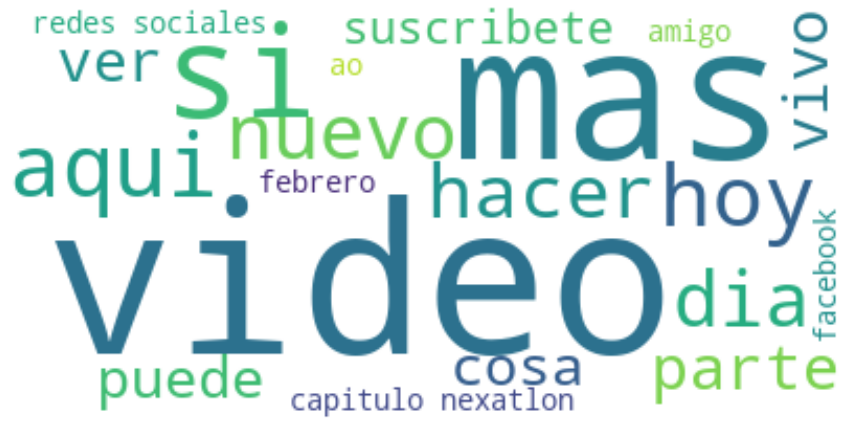

In [261]:
robo = dfym[dfym.delito=="robo objetos"]
text = " ".join(frase for frase in robo["Titulo + Descripcion"])
wordcloud = WordCloud( max_words=20, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Probando el modelo para predecir el crimen

In [ ]:
cv = CountVectorizer(max_features=10000, ngram_range=(1,2))
X = cv.fit_transform(dfym["Titulo + Descripcion"]).toarray()
y = dfym['delito'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
nb_y_pred = nb_classifier.predict(X_test)

In [ ]:
score = accuracy_score(y_test, nb_y_pred)
score = score*100
score

37.03932723225328

**Predecir el delito mediante NV usando solo el titulo**




In [ ]:
cv = CountVectorizer(max_features=10000, ngram_range=(1,2))
X = cv.fit_transform(dfym["Titulo + Descripcion"]).toarray()
y = dfym['delito'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
nb_y_pred = nb_classifier.predict(X_test)

In [ ]:
score = accuracy_score(y_test, nb_y_pred)
score = score*100
score

37.03932723225328

**Predecir el delito  mediante NV usando solo la descripcion**

In [ ]:
cv = CountVectorizer(max_features=10000, ngram_range=(1,2))
X = cv.fit_transform(dfym["Titulo + Descripcion"]).toarray()
y = dfym['delito'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
nb_y_pred = nb_classifier.predict(X_test)

In [ ]:
score = accuracy_score(y_test, nb_y_pred)
score = score*100
score

37.03932723225328